# W3 - Graphs & Fields

In this workshop we will learn about graphs & fields, and explore their application in configuration design.

## 0. Initialization

In [1]:
import networkx as nx 
import topogenesis as tg

## 1. Graphs

In [2]:
G = nx.Graph([
    (1, 2),
    (1, 3),
    (1, 5),
    (2, 3),
    (3, 4),
    (4, 5)])

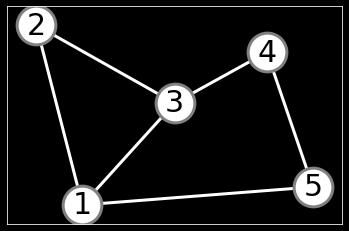

In [3]:
# explicitly set positions
pos = { 
    1: (0, 0), 
    2: (-1, 0.3), 
    3: (2, 0.17), 
    4: (4, 0.255), 
    5: (5, 0.03)}

options = {
    "font_size": 30,
    "node_size": 1500,
    "node_color": "white",
    "edgecolors": "grey",
    "edge_color": "white",
    "linewidths": 3,
    "width": 3,
}
nx.draw_networkx(G, pos, **options)

In [ ]:
# TODO Explain graph related matrices, VV (adjacency matrix), VE, EV, EE
# TODO explain Activity Relationship Chart (REL Chart)

## 2. Fields

In [ ]:
# TODO import the street network mesh
# TODO voxelate the mesh
# TODO Explain poincare duality on lattices
# TODO Explain shortest distance
# TODO Construct the distance lattice

## 3. Spatial Networks

## Credits

In [ ]:
__author__ = "Shervin Azadi"
__license__ = "MIT"
__version__ = "1.0"
__url__ = "https://github.com/shervinazadi/earthy_workshops"
__summary__ = "Earthy Design Studio"